In [1]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import yfinance as yf # type: ignore

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Load financial data

In [2]:
data = yf.download('AAPL')

[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600
1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800
1980-12-16,0.086802,0.112723,0.113281,0.112723,0.113281,105728000
1980-12-17,0.088951,0.115513,0.116071,0.115513,0.115513,86441600
1980-12-18,0.091530,0.118862,0.119420,0.118862,0.118862,73449600


In [4]:
X = data.to_numpy()
X.shape

(11090, 6)

In [5]:
def create_sequence(data: np.ndarray, seq_len: int = 8) -> tuple[np.ndarray, np.ndarray]:
    X = []
    y = []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

# Split and scale

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()

X_train, X_test = train_test_split(X, test_size=0.2)

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

print(f'Train: {X_train.shape}, Test: {X_test.shape}')

Train: (8872, 6), Test: (2218, 6)


# Create sequences

In [7]:
X_train, y_train = create_sequence(X_train)
X_test, y_test = create_sequence(X_test)

print(f'X, y_train: {X_train.shape} {y_train.shape}')
print(f'X, y_test: {X_test.shape} {y_test.shape}')

X, y_train: (8864, 8, 6) (8864, 6)
X, y_test: (2210, 8, 6) (2210, 6)


# Custom dataset

In [8]:
class StockDataset(Dataset):

    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves the data and label at the given index.
        
        Args:
            idx (int): The index of the sample to retrieve.
        
        Returns:
            tuple: (data, label)
        """
        sample = self.data[idx]
        target = self.targets[idx]
        return sample, target

# Data preparation

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train, X_test, y_train, y_test = torch.Tensor(X_train), torch.Tensor(X_test), torch.Tensor(y_train), torch.Tensor(y_test)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

In [10]:
batch_size = 32

dataset_train = StockDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_test = StockDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

# Encoder only Transformer

In [11]:
from torch_fin_transformer import FinancialTransformer

seq_len = 8
n_features = 6  # Number of financial indicators

model = FinancialTransformer(d_model=n_features, n_heads=3, d_ff=2048, n_enc_layers=6, n_features=n_features, seq_len=seq_len)
model = model.to(device)

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

model.train()

for epoch in range(100):

    epoch_loss = 0

    for data, target in dataloader_train:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch: {epoch+1}, Loss: {epoch_loss / len(dataloader_train)}")

Epoch: 1, Loss: 1.0240203929722094
Epoch: 2, Loss: 1.0053875508721555
Epoch: 3, Loss: 1.0041107626275465
Epoch: 4, Loss: 1.0022381346686222
Epoch: 5, Loss: 1.0018735464514377
Epoch: 6, Loss: 1.0016796292488326
Epoch: 7, Loss: 1.0013633426346074
Epoch: 8, Loss: 1.0017061058149441
Epoch: 9, Loss: 1.0016032923752651
Epoch: 10, Loss: 1.0013734354546784
Epoch: 11, Loss: 1.0013972744076691
Epoch: 12, Loss: 1.001351604823171
Epoch: 13, Loss: 1.001472772082267
Epoch: 14, Loss: 1.001554022304418
Epoch: 15, Loss: 1.0013389584712604
Epoch: 16, Loss: 1.0014451905170503
Epoch: 17, Loss: 1.0010912400613192
Epoch: 18, Loss: 1.0017040718871333
Epoch: 19, Loss: 1.0011921912862076
Epoch: 20, Loss: 1.0013087730760608
Epoch: 21, Loss: 1.0012242062427508


KeyboardInterrupt: 

In [13]:
model.eval()

with torch.no_grad():

    val_output = model(X_test)
    val_loss = criterion(val_output, y_test)
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 1.0247694253921509


In [14]:
true_unscaled = scaler_X.inverse_transform(y_test.cpu())[:100]
predicted_unscaled = scaler_X.inverse_transform(val_output.cpu())[:100]
print(f'Shapes: {true_unscaled.shape}, {predicted_unscaled.shape}')

Shapes: (100, 6), (100, 6)


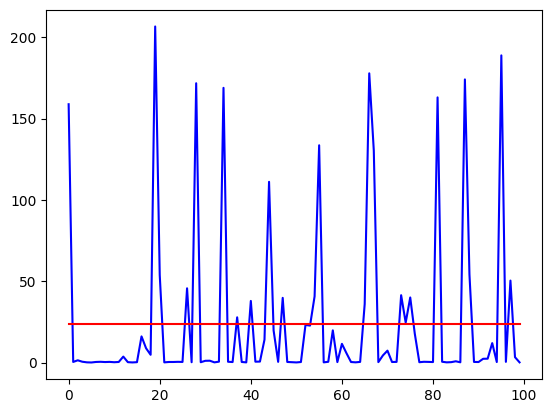

In [15]:
x = [i for i in range(len(true_unscaled))]
plt.plot(x, true_unscaled[:, 3], color='blue')
plt.plot(x,predicted_unscaled[:, 3], color='red')
plt.show()